In [39]:
#Importar librerías
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

#Audio
import librosa
import librosa.display
import soundfile as sf

#Extracción características audios
import os
import re

#Estandarización datos
from sklearn.preprocessing import MinMaxScaler

#Preparación de datos y configuración de pipeline para Machine Learning con scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
#for classification
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report


In [2]:
# Leer el audio (.wav)
audio, sr = sf.read('./Data/Canto1_2019.WAV')
print(audio)
print('Largo del array:', len(audio))
print('Frecuencia de muestreo:', sr)
print('Duración:', len(audio)/sr, 'segundos')

[0.0088501  0.00952148 0.00906372 ... 0.14505005 0.14559937 0.1451416 ]
Largo del array: 2563974
Frecuencia de muestreo: 44100
Duración: 58.14 segundos


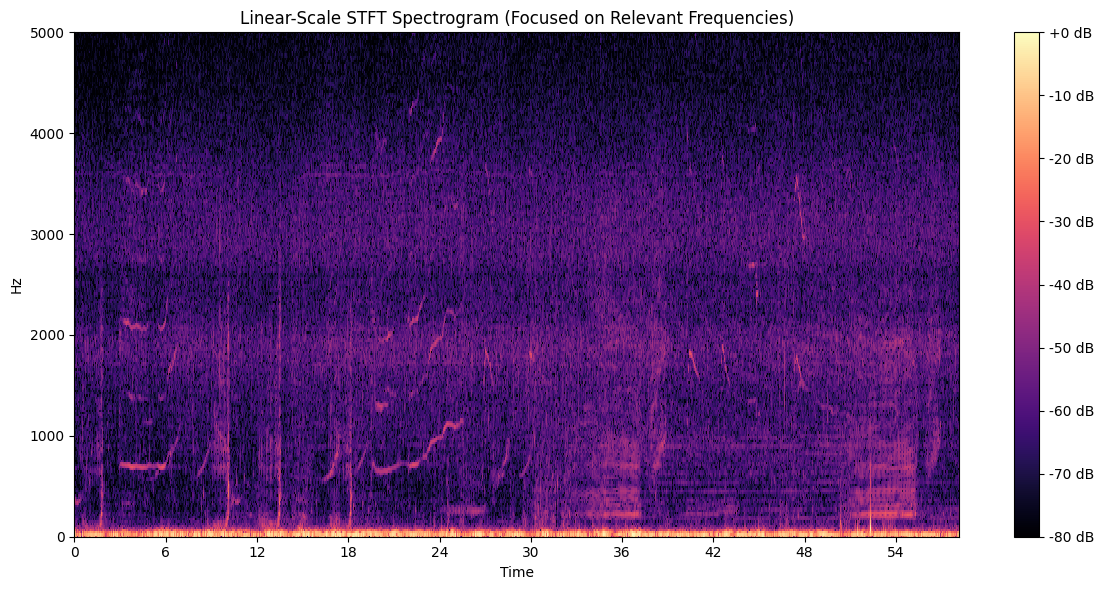

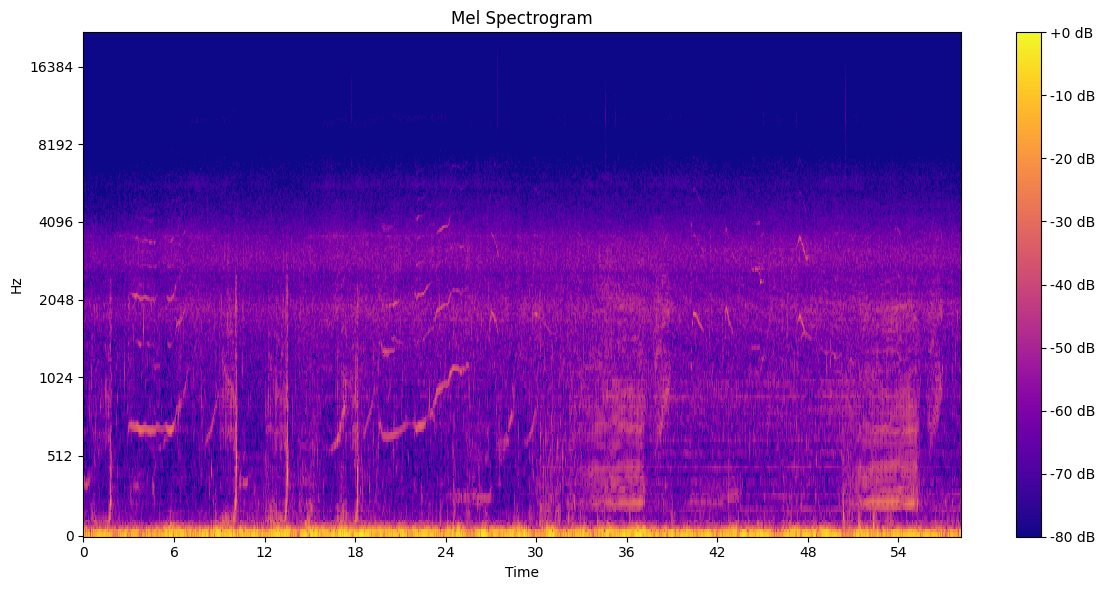

In [3]:
# Parameters
hop_length = int(sr * 0.005)  # 10 ms hop
frame_length = int(sr * 0.01)  # 50 ms frame

# STFT Spectrogram
S = librosa.stft(audio, n_fft=2048, hop_length=hop_length)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear', cmap='magma')

# Limitar la escala del eje Y (frecuencia)
plt.ylim(0, 5000)  # Visualiza solo las frecuencias de 0 a 5000 Hz (ajusta según lo necesario)

plt.colorbar(format='%+2.0f dB')
plt.title("Linear-Scale STFT Spectrogram (Focused on Relevant Frequencies)")
plt.tight_layout()
plt.show()

# Mel Spectrogram
M = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=256, fmax=sr / 2)  # Aumenta n_mels
M_db = librosa.power_to_db(M, ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(M_db, sr=sr, x_axis='time', y_axis='mel', cmap='plasma')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.tight_layout()
plt.show()

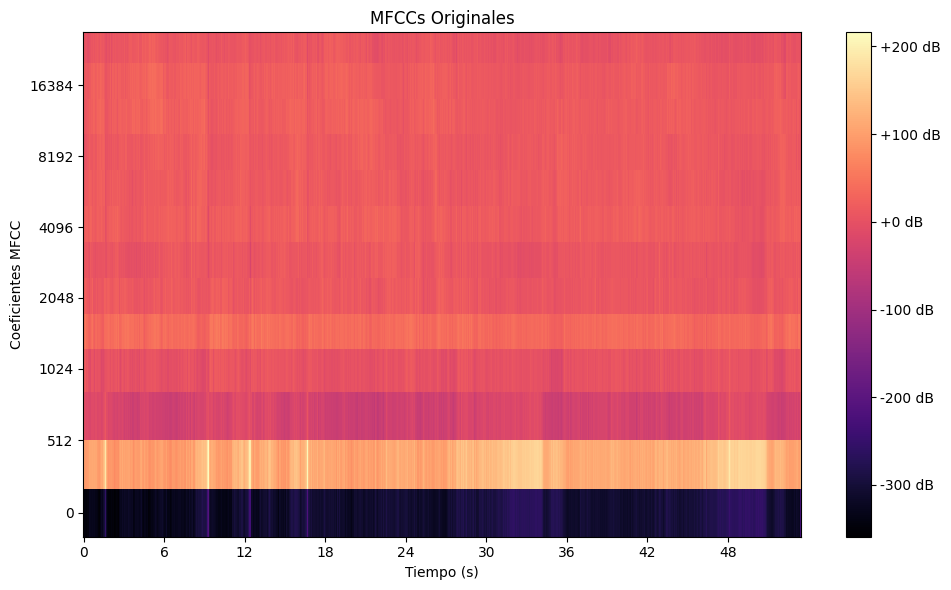

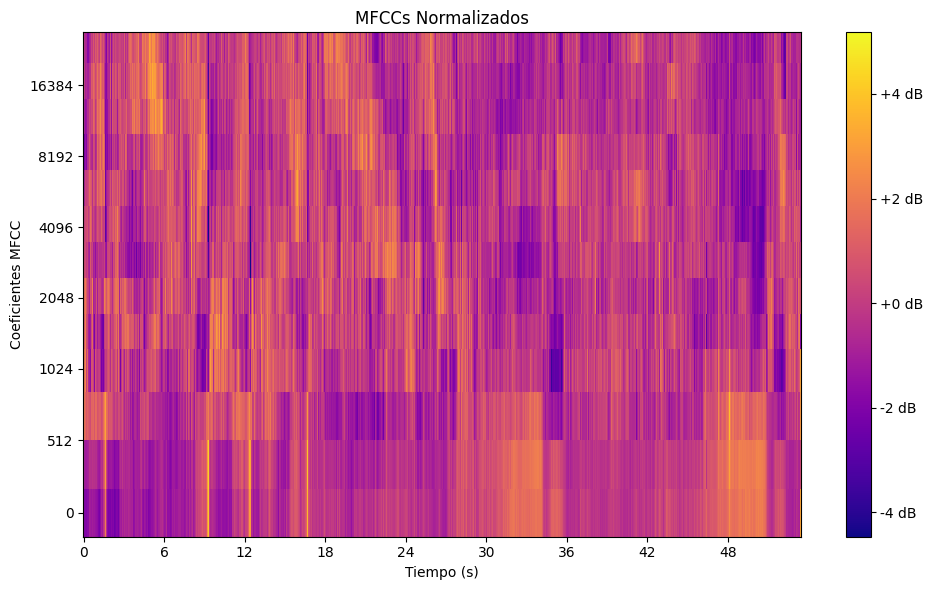

In [7]:
#Gráfico MFCC
# Parámetros
hop_length = int(sr * 0.02)  # Hop length de 20 ms
frame_length = hop_length * 4  # Ventana de 80 ms

# Calcular MFCCs
MFCC = librosa.feature.mfcc(y=audio, sr=sr, n_fft=frame_length, hop_length=hop_length, n_mfcc=13)

# Gráfico de los MFCCs originales
plt.figure(figsize=(10, 6))
librosa.display.specshow(MFCC, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("MFCCs Originales")
plt.ylabel("Coeficientes MFCC")
plt.xlabel("Tiempo (s)")
plt.tight_layout()
plt.show()

# Normalización de los MFCCs
MFCC_normalized = (MFCC - MFCC.mean(axis=1, keepdims=True)) / MFCC.std(axis=1, keepdims=True)

# Gráfico de los MFCCs normalizados
plt.figure(figsize=(10, 6))
librosa.display.specshow(MFCC_normalized, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='plasma')
plt.colorbar(format='%+2.0f dB')
plt.title("MFCCs Normalizados")
plt.ylabel("Coeficientes MFCC")
plt.xlabel("Tiempo (s)")
plt.tight_layout()
plt.show()

In [26]:
#Extracciión de las características de TODOS los audios en la base de datos
# Ruta donde están los archivos de audio
audio_folder = "./Data"  # Cambia esto a la carpeta con los archivos de audio

# Obtener todos los archivos de audio en la carpeta
audio_files = os.listdir(audio_folder)

# Lista para almacenar las características y el año
data = []

print(audio_files)

# Procesar cada archivo de audio
    # Ruta completa al archivo
for file in audio_files:
    filepath = os.path.join(audio_folder, file)
    
    # Extraer el año del nombre del archivo usando una expresión regular
    match = re.search(r'\d{4}', file)  # Buscar un patrón de 4 dígitos (ejemplo: 2020)
    if match:
        year = int(match.group())  # Convertir el año a entero
    else:
        print(f"No se encontró un año en el archivo: {file}")
        continue

    try:
        # Cargar el audio
        y, sr = librosa.load(filepath, sr=None)

        # Extraer características básicas
        duration = librosa.get_duration(y=y, sr=sr)
        mean_freq = np.mean(librosa.fft_frequencies(sr=sr))
        max_magnitude = np.max(np.abs(y))
        mean_magnitude = np.mean(np.abs(y))

        # MFCCs
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Mel-Spectrogram
        nmel=40
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=nmel)
        mel_mean = np.mean(mel, axis=1)

        # Agregar características al dataset
        data.append({
            "audio_file": file,
            "duration": duration,
            "mean_freq": mean_freq,
            "max_magnitude": max_magnitude,
            "mean_magnitude": mean_magnitude,
            **{f"mfcc_{i+1}": mfcc_mean[i] for i in range(len(mfcc_mean))},
            **{f"mel_{i+1}": mel_mean[i] for i in range(len(mel_mean))},
            "year": year  # Etiqueta (año)
        })
    except Exception as e:
        print(f"Error procesando {file}: {e}")

# Crear un DataFrame con las características y el año
df = pd.DataFrame(data)

# Guardar el dataset para uso futuro
df.to_csv("audio_features_with_year.csv", index=False)

print("Dataset generado con éxito. Guardado en 'audio_features_with_year.csv'.")

['Canto10_2017.WAV', 'Canto10_2018.wav', 'Canto10_2019.WAV', 'Canto10_2022.wav', 'Canto10_2023.wav', 'Canto10_2024.wav', 'Canto11_2017.WAV', 'Canto11_2018.wav', 'Canto11_2019.WAV', 'Canto11_2022.wav', 'Canto11_2023.wav', 'Canto11_2024.wav', 'Canto12_2017.WAV', 'Canto12_2018.wav', 'Canto12_2019.WAV', 'Canto12_2023.wav', 'Canto12_2024.wav', 'Canto13_2017.WAV', 'Canto13_2018.wav', 'Canto13_2019.WAV', 'Canto13_2023.wav', 'Canto13_2024.wav', 'Canto14_2017.WAV', 'Canto14_2018.WAV', 'Canto14_2019.WAV', 'Canto14_2023.wav', 'Canto14_2024.wav', 'Canto15_2017.WAV', 'Canto15_2018.wav', 'Canto15_2019.WAV', 'Canto15_2023.wav', 'Canto15_2024.wav', 'Canto16_2017.WAV', 'Canto16_2018.WAV', 'Canto16_2019.wav', 'Canto16_2024.wav', 'Canto17_2017.WAV', 'Canto17_2018.wav', 'Canto17_2019.WAV', 'Canto17_2024.wav', 'Canto18_2017.WAV', 'Canto18_2018.wav', 'Canto18_2019.WAV', 'Canto18_2024.wav', 'Canto19_2017.WAV', 'Canto19_2018.wav', 'Canto19_2019.WAV', 'Canto19_2024.wav', 'Canto1_2017.WAV', 'Canto1_2018.wav', '

In [25]:
#Escalar las variables del dataframe, excepto año que es la variable objetivo y se elimina la columna donde se contiene el nombre del archivo

# Se carga el dataset
df = pd.read_csv("audio_features_with_year.csv")

# Definir las columnas no escaladas
no_escalar = ['audio_file', 'year']

# Eliminar 'audio_file' desde el principio (no será incluida en el dataset final)
df = df.drop(columns=['audio_file'])

# Separar las columnas no escaladas y el resto de características
no_escaladas_df = df[no_escalar[1:]]  # Seleccionar columnas que no serán escaladas, excluyendo 'audio_file'
X = df.drop(columns=no_escalar[1:])  # Eliminar las columnas no escaladas del DataFrame para su procesamiento

# Escalar las características numéricas entre 0 y 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convertir a DataFrame para mantener los nombres de las columnas originales
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Concatenar las columnas no escaladas y las características escaladas
final_df = pd.concat([no_escaladas_df.reset_index(drop=True), X_scaled_df], axis=1)

# 8. Guardar el dataset final escalado
final_df.to_csv("audio_features_scaled.csv", index=False)

print("Los datos han sido escalados y guardados en 'audio_features_scaled.csv'.")

Los datos han sido escalados y guardados en 'audio_features_scaled.csv'.


Matriz de correlación calculada.


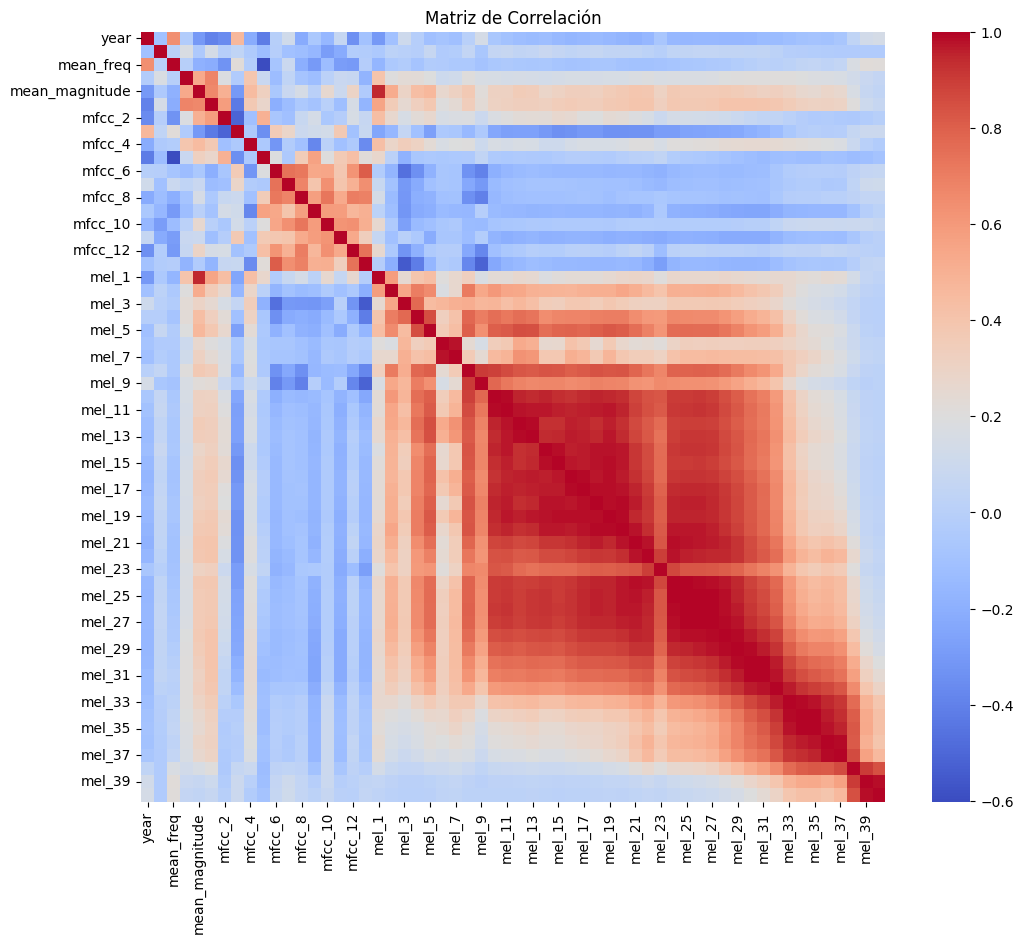

In [5]:
#Análisis de los datos con la Matriz de Correlación

# Cargar el dataset escalado
df = pd.read_csv("audio_features_scaled.csv")

# Calcular la matriz de correlación
correlation_matrix = df.corr()  # Excluimos 'audio_file'
print("Matriz de correlación calculada.")

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Matriz de Correlación")
plt.show()

In [29]:
#Se carga el data set con los datos escalados y se visualiza el archivo
data = pd.read_csv('audio_features_scaled.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 58 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            223 non-null    int64  
 1   duration        223 non-null    float64
 2   mean_freq       223 non-null    float64
 3   max_magnitude   223 non-null    float64
 4   mean_magnitude  223 non-null    float64
 5   mfcc_1          223 non-null    float64
 6   mfcc_2          223 non-null    float64
 7   mfcc_3          223 non-null    float64
 8   mfcc_4          223 non-null    float64
 9   mfcc_5          223 non-null    float64
 10  mfcc_6          223 non-null    float64
 11  mfcc_7          223 non-null    float64
 12  mfcc_8          223 non-null    float64
 13  mfcc_9          223 non-null    float64
 14  mfcc_10         223 non-null    float64
 15  mfcc_11         223 non-null    float64
 16  mfcc_12         223 non-null    float64
 17  mfcc_13         223 non-null    flo

In [33]:
data.head(214)

,year,duration,mean_freq,max_magnitude,mean_magnitude,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,...,mel_31,mel_32,mel_33,mel_34,mel_35,mel_36,mel_37,mel_38,mel_39,mel_40
0,2017,0.365922,0.0,0.997974,0.791444,0.903443,0.684795,0.468195,0.833209,0.710991,...,0.032975,0.035196,0.027451,0.017372,0.012872,0.010474,0.008961,0.005728,2.057467e-03,1.435491e-03
1,2018,0.463833,0.0,0.487428,0.044178,0.671019,0.512160,0.533300,0.332610,0.813007,...,0.000187,0.000264,0.000257,0.000219,0.000159,0.000105,0.000088,0.000136,3.247031e-05,3.840017e-05
2,2019,0.189945,0.0,0.997944,0.047872,0.708940,0.286240,0.673018,0.441174,0.649758,...,0.000144,0.000231,0.000481,0.000476,0.000237,0.000095,0.000058,0.000039,1.696048e-05,1.026690e-05
3,2022,0.074757,0.0,0.668605,0.122387,0.653358,0.318122,0.807569,0.560554,0.652991,...,0.000061,0.000157,0.000204,0.000170,0.000138,0.000091,0.000074,0.000027,5.764756e-06,1.222781e-05
4,2023,0.306608,1.0,0.706464,0.125490,0.675810,0.355118,0.911322,0.496663,0.362011,...,0.006164,0.009977,0.013677,0.015090,0.017099,0.014925,0.021487,0.037223,2.784880e-02,3.552191e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,2023,0.226320,1.0,0.706464,0.128959,0.673617,0.266003,0.645860,0.248201,0.540171,...,0.001735,0.002653,0.003527,0.003911,0.004028,0.003652,0.004831,0.007811,5.459718e-03,7.356508e-03
210,2024,0.000715,1.0,0.288251,0.090710,0.604136,0.421906,0.809123,0.395423,0.584817,...,0.000273,0.000453,0.000594,0.000619,0.000640,0.000484,0.000430,0.000416,2.302759e-04,3.314759e-04
211,2017,0.076767,0.0,0.997974,0.669939,1.000000,0.334052,0.470226,0.750464,0.608543,...,0.635029,0.861515,0.975339,0.916821,0.980865,1.000000,1.000000,0.701089,2.262575e-01,1.192788e-01
212,2018,0.519327,0.0,0.417528,0.046565,0.625772,0.400752,0.666740,0.406007,0.710790,...,0.000006,0.000006,0.000004,0.000002,0.000002,0.000002,0.000002,0.000001,5.910932e-07,7.364511e-07


In [7]:
#Selección de la caracteristica o función objetivo y el resto de los datos
X = data.drop(['year'],axis=1)
y = data['year']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
#Aplicación algoritmos de Clasificiación 
#Gaussian Naive Bayes Application - Aplicación de Gaussian Naive Bayes
model = GaussianNB()
model.fit(X_train,y_train)

GaussianNB()

In [9]:
y_predict = model.predict(X_test)

The accuracy of GaussianNB is 0.4651


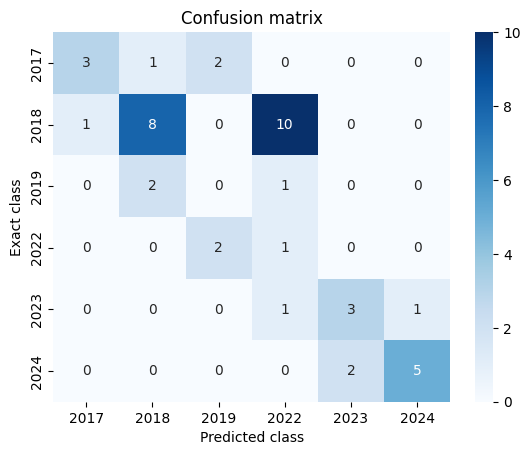

In [11]:
# Etiquetas de los años
year_labels = ['2017', '2018', '2019', '2022', '2023', '2024']

accuracy = accuracy_score(y_test,y_predict)
print('The accuracy of GaussianNB is {:.4f}'.format(accuracy))

confus_matrix = confusion_matrix(y_test,y_predict)
plt.title('Confusion matrix')
sns.heatmap(confus_matrix, annot=True, cmap='Blues', xticklabels=year_labels, yticklabels=year_labels)
plt.xlabel('Predicted class')
plt.ylabel('Exact class');

serie = pd.Series(accuracy,index=['GaussianNB'])
accuracy_NBmodel = pd.DataFrame({'accuracy':serie})

In [12]:
# Logistic Regression Application - Aplicación de Regresión Logística
model = LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [13]:
y_predict = model.predict(X_test)

The accuracy of Logistic Regression is 0.7442


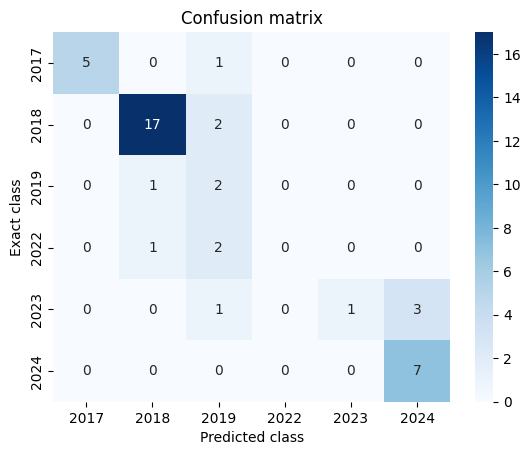

In [14]:
# Etiquetas de los años
year_labels = ['2017', '2018', '2019', '2022', '2023', '2024']

accuracy = accuracy_score(y_test,y_predict)
print('The accuracy of Logistic Regression is {:.4f}'.format(accuracy))

confus_matrix = confusion_matrix(y_test,y_predict)
plt.title('Confusion matrix')
sns.heatmap(confus_matrix, annot=True, cmap='Blues', xticklabels=year_labels, yticklabels=year_labels)
plt.xlabel('Predicted class')
plt.ylabel('Exact class');

serie = pd.Series(accuracy,index=['LogisticRegression'])
accuracy_Logmodel = pd.DataFrame({'accuracy':serie})

In [15]:
#Decision tree Application - Aplicación de Arboles de decisión
model = DecisionTreeClassifier()
model.fit(X_train,y_train)

DecisionTreeClassifier()

In [16]:
y_predict = model.predict(X_test)

The accuracy of Decision Tree is 0.8140


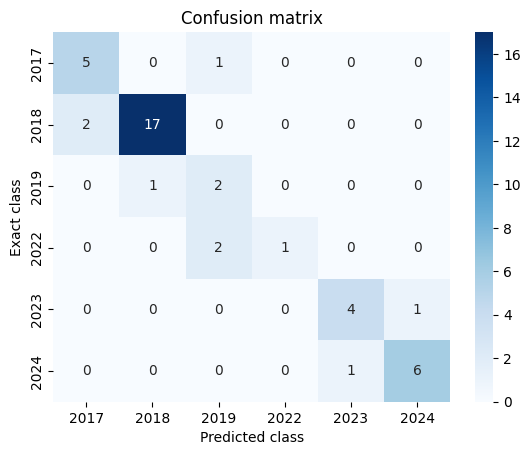

In [17]:
# Etiquetas de los años
year_labels = ['2017', '2018', '2019', '2022', '2023', '2024']

accuracy = accuracy_score(y_test,y_predict)
print('The accuracy of Decision Tree is {:.4f}'.format(accuracy))

confus_matrix = confusion_matrix(y_test,y_predict)
plt.title('Confusion matrix')
sns.heatmap(confus_matrix, annot=True, cmap='Blues', xticklabels=year_labels, yticklabels=year_labels)
plt.xlabel('Predicted class')
plt.ylabel('Exact class');

serie = pd.Series(accuracy,index=['DecisionTreeClassifier'])
accuracy_DTmodel = pd.DataFrame({'accuracy':serie})

In [18]:
#Random Forest Application - Aplicación de Bosques Aleatorios
model = RandomForestClassifier(n_estimators=10)
model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10)

In [19]:
y_predict = model.predict(X_test)

The accuracy of RandomForestClassifier is 0.8140


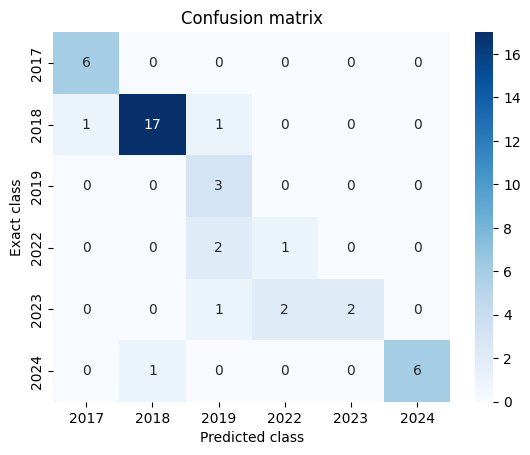

In [20]:
# Etiquetas de los años
year_labels = ['2017', '2018', '2019', '2022', '2023', '2024']

accuracy = accuracy_score(y_test,y_predict)
print('The accuracy of RandomForestClassifier is {:.4f}'.format(accuracy))

confus_matrix = confusion_matrix(y_test,y_predict)
plt.title('Confusion matrix')
sns.heatmap(confus_matrix, annot=True, cmap='Blues', xticklabels=year_labels, yticklabels=year_labels)
plt.xlabel('Predicted class')
plt.ylabel('Exact class');

serie = pd.Series(accuracy,index=['RandomForestClassifier'])
accuracy_RFmodel = pd.DataFrame({'accuracy':serie})

In [21]:
degree = np.arange(1,21)
train_score, val_score = validation_curve(RandomForestClassifier(), X, y, param_name = 'n_estimators' ,param_range=degree,cv=5)

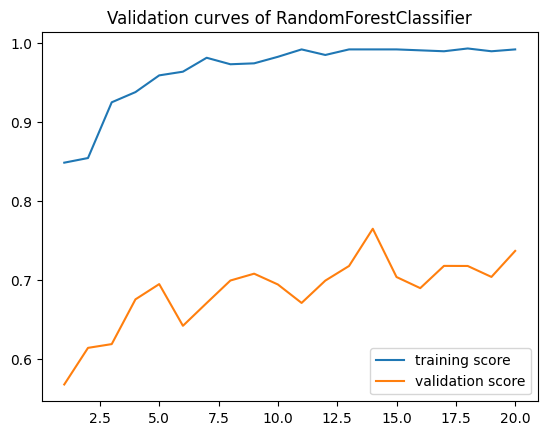

In [82]:
plt.title('Validation curves of RandomForestClassifier')
plt.plot(degree,train_score.mean(axis = 1), label = 'training score')
plt.plot(degree,val_score.mean(axis = 1), label = 'validation score')
plt.legend();

In [36]:
# KNeighbors Application - Aplicación de Clasificador de vecinos mas cercanos

model = KNeighborsClassifier()
model.fit(X_train,y_train)

KNeighborsClassifier()

In [37]:
y_predict = model.predict(X_test)

The accuracy of KNeighborsClassifier is 0.8372
Reporte de clasificación:
 <function classification_report at 0x0000012A943A5B20>
Reporte de clasificación:
               precision    recall  f1-score   support

        2017       0.86      1.00      0.92         6
        2018       0.95      0.95      0.95        19
        2019       0.75      1.00      0.86         3
        2022       1.00      1.00      1.00         3
        2023       1.00      0.20      0.33         5
        2024       0.56      0.71      0.62         7

    accuracy                           0.84        43
   macro avg       0.85      0.81      0.78        43
weighted avg       0.87      0.84      0.82        43



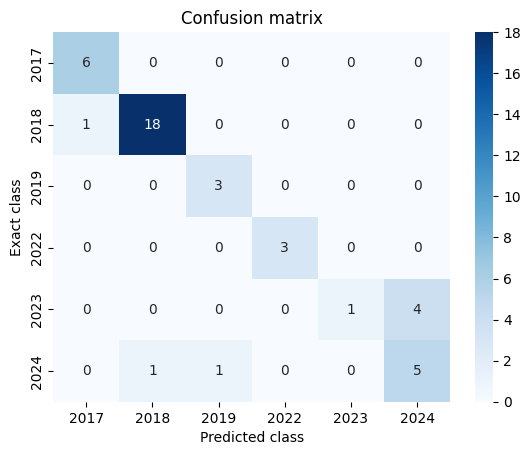

In [40]:
# Etiquetas de los años
year_labels = ['2017', '2018', '2019', '2022', '2023', '2024']

accuracy = accuracy_score(y_test,y_predict)
print('The accuracy of KNeighborsClassifier is {:.4f}'.format(accuracy))

#Reporte de clasificacion
classification_report(y_test, y_predict) 
print("Reporte de clasificación:\n",classification_report)
print("Reporte de clasificación:\n", classification_report(y_test, y_predict))

confus_matrix = confusion_matrix(y_test,y_predict)
plt.title('Confusion matrix')
sns.heatmap(confus_matrix, annot=True, cmap='Blues', xticklabels=year_labels, yticklabels=year_labels)
plt.xlabel('Predicted class')
plt.ylabel('Exact class');

serie = pd.Series(accuracy,index=['KNeighborsClassifier'])
accuracy_KNmodel = pd.DataFrame({'accuracy':serie})

In [97]:
#Se realiza vlidacion cruzada para medir el rendimiento del algoritmo
degree = np.arange(1,21)
train_score, val_score = validation_curve(KNeighborsClassifier(), X, y, param_name = 'n_neighbors' ,param_range=degree,cv=5)

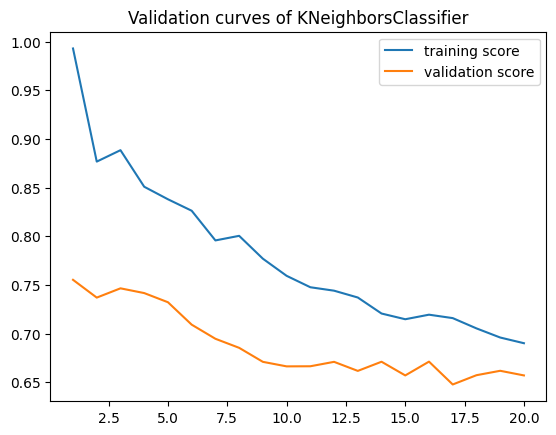

In [98]:
plt.title('Validation curves of KNeighborsClassifier')
plt.plot(degree,train_score.mean(axis = 1), label = 'training score')
plt.plot(degree,val_score.mean(axis = 1), label = 'validation score')
plt.legend();

In [100]:
#Comparación del rendimiento de cada uno de los algoritmos utilizados

accuracy_models = pd.concat([accuracy_Logmodel,accuracy_NBmodel,accuracy_DTmodel,accuracy_RFmodel,accuracy_KNmodel])
accuracy_models

,accuracy
LogisticRegression,0.744186
GaussianNB,0.465116
DecisionTreeClassifier,0.790698
RandomForestClassifier,0.813953
KNeighborsClassifier,0.837209


In [101]:
#Predicciones
# Mostrar las primeras 10 predicciones
print("Primeras 10 predicciones:", y_predict[:10])

Primeras 10 predicciones: [2022 2024 2017 2018 2018 2019 2024 2017 2018 2018]


In [102]:
# Crear un DataFrame para comparar
predicciones_comparacion = pd.DataFrame({
    'Actual Value': y_test,        # Valores reales
    'Predicted Value': y_predict   # Valores predichos
})

# Mostrar las primeras 10 filas
print(predicciones_comparacion.head(10))

     Actual Value  Predicted Value
9            2022             2022
197          2023             2024
66           2017             2017
191          2018             2018
117          2018             2018
111          2024             2019
15           2023             2024
86           2017             2017
75           2018             2018
144          2018             2018


In [103]:
#Pruebas con archivos que el modelo no conoce 
pd.read_csv('audios_predicciones.csv')

,duration,mean_freq,max_magnitude,mean_magnitude,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,...,mel_31,mel_32,mel_33,mel_34,mel_35,mel_36,mel_37,mel_38,mel_39,mel_40
0,0.172098,0.0,0.997974,0.414381,0.784210,0.495728,0.585260,0.459847,0.811677,0.544788,...,0.000703,0.000742,0.000702,0.000518,0.000447,0.000473,0.000447,0.000308,1.274952e-04,8.240390e-05
1,0.178467,0.0,0.499459,0.053960,0.686033,0.406364,0.601962,0.444868,0.791227,0.596998,...,0.008091,0.011345,0.012856,0.011364,0.010230,0.006636,0.004926,0.003941,1.796824e-03,2.167517e-03
2,0.365845,0.0,0.997944,0.049158,0.725834,0.432923,0.500919,0.478585,0.726385,0.431331,...,0.000825,0.001429,0.002179,0.002274,0.001678,0.000997,0.000779,0.000608,2.941430e-04,1.733012e-04
3,0.281806,0.0,0.997974,0.089981,0.692573,0.285843,0.828104,0.507961,0.480363,0.755410,...,0.000060,0.000181,0.000242,0.000192,0.000140,0.000085,0.000065,0.000023,5.263151e-06,1.218550e-05
4,0.085682,1.0,0.706464,0.041868,0.646236,0.168733,0.713475,0.622911,0.749381,0.795571,...,0.001146,0.001778,0.002091,0.001845,0.001845,0.002085,0.003412,0.005216,3.430576e-03,4.442382e-03
5,0.066140,1.0,0.997944,0.116978,0.727167,0.376520,0.837601,0.475535,0.539436,0.771050,...,0.000248,0.000550,0.000652,0.000612,0.000635,0.000464,0.000431,0.000454,1.893991e-04,1.730522e-04
6,0.519327,0.0,0.417528,0.046565,0.625772,0.400752,0.666740,0.406007,0.710790,0.604071,...,0.000006,0.000006,0.000004,0.000002,0.000002,0.000002,0.000002,0.000001,5.910932e-07,7.364511e-07
7,0.037268,0.0,0.407751,0.006633,0.604593,0.370281,0.671648,0.454302,0.651844,0.541092,...,0.000015,0.000017,0.000011,0.000006,0.000006,0.000008,0.000007,0.000004,1.859442e-06,2.167499e-06
8,0.530736,0.0,0.499231,0.040369,0.648633,0.332650,0.551883,0.462025,0.861838,0.623310,...,0.000021,0.000046,0.000110,0.000122,0.000078,0.000035,0.000022,0.000016,7.395918e-06,8.478218e-06
9,0.543676,0.0,0.499139,0.052986,0.656181,0.431597,0.569873,0.319845,0.761555,0.637027,...,0.000025,0.000055,0.000120,0.000106,0.000066,0.000031,0.000020,0.000014,6.065535e-06,6.629221e-06


In [ ]:
# Cargar DataFrame llamado new_data con los datos nuevos
new_data=pd.read_csv('audios_predicciones.csv')


# Realizar las predicciones
predicciones_nuevas = model.predict(new_data)

# Combinar las características y las predicciones en un DataFrame
resultados = new_data.copy()  # Copia los datos originales
resultados['Predicted Value'] = predicciones_nuevas  # Añadir columna de predicciones

# Mostrar las primeras filas de los resultados
print(resultados.head())

# Exportar los resultados a un archivo CSV para análisis posterior
resultados.to_csv('predicciones_con_features.csv', index=False)
print("Resultados exportados a 'predicciones_con_features.csv'")

   duration  mean_freq  max_magnitude  mean_magnitude    mfcc_1    mfcc_2  \
0  0.172098        0.0       0.997974        0.414381  0.784210  0.495728   
1  0.178467        0.0       0.499459        0.053960  0.686033  0.406364   
2  0.365845        0.0       0.997944        0.049158  0.725834  0.432923   
3  0.281806        0.0       0.997974        0.089981  0.692573  0.285843   
4  0.085682        1.0       0.706464        0.041868  0.646236  0.168733   

     mfcc_3    mfcc_4    mfcc_5    mfcc_6  ...    mel_32    mel_33    mel_34  \
0  0.585260  0.459847  0.811677  0.544788  ...  0.000742  0.000702  0.000518   
1  0.601962  0.444868  0.791227  0.596998  ...  0.011345  0.012856  0.011364   
2  0.500919  0.478585  0.726385  0.431331  ...  0.001429  0.002179  0.002274   
3  0.828104  0.507961  0.480363  0.755410  ...  0.000181  0.000242  0.000192   
4  0.713475  0.622911  0.749381  0.795571  ...  0.001778  0.002091  0.001845   

     mel_35    mel_36    mel_37    mel_38    mel_39    m